# hypopy tutorial

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import hypo

## Joint hypocenter-velocity inversion with P-wave arrivals only

### Create first synthetic data

Define limits and build grid

In [2]:
xmin = 90.0
xmax = 211.0
ymin = 80.0
ymax = 211.0
zmin = 0.0
zmax = 101.0

dx = 7.5   # grid cell size, we use cubic cells here

g = hypo.Grid3D(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dx), np.arange(zmin, zmax, dx))

We need some receivers

In [3]:
rcv = np.array([[112., 115., 13.],
                [151., 117., 17.],
                [180., 115., 16.],
                [113., 145., 11.],
                [160., 150., 17.],
                [185., 149., 15.],
                [117., 184., 11.],
                [155., 192.,  9.],
                [198., 198., 10.],
                [198., 196., 40.],
                [198., 193., 90.]])
nsta = rcv.shape[0]

Let's create 15 events randomly located in the grid

In [4]:
nev = 15
src = np.vstack((np.arange(nev),                                            # event ID
                 np.linspace(0., 50., nev) + np.random.randn(nev),          # origin time
                 160. + 10.*np.random.randn(nev),                           # x
                 140. + 10.*np.random.randn(nev),                           # y
                  35. + 10.*np.random.randn(nev))).T                        # z

h_true = src.copy()

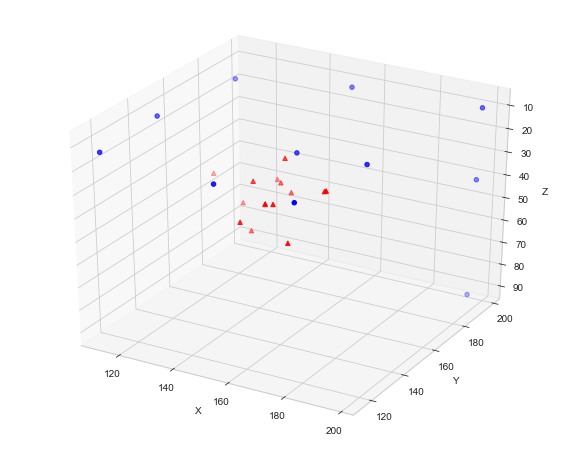

In [5]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rcv[:,0], rcv[:,1], rcv[:,2], c='b', marker='o')
ax.scatter(src[:,2], src[:,3], src[:,4], c='r', marker='^')
ax.invert_zaxis()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

For simplicity, we will use a velocity model with a small vertical gradient and mean Vp = 4000 m/s

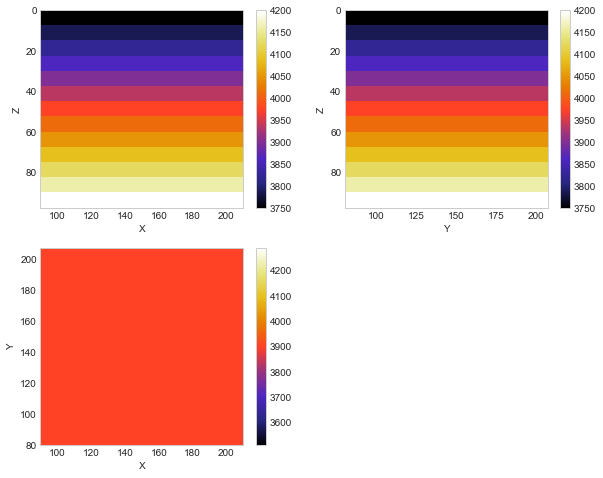

In [6]:
x = np.arange(xmin, xmax, dx)
y = np.arange(ymin, ymax, dx)
z = np.arange(zmin, zmax, dx)
def Vz(z):
    return 4000.0 + 5.0*(z-50.0)
Vp = np.kron(Vz(z), np.ones((g.shape[0], g.shape[1], 1)))

plt.figure(figsize=(10,8))
plt.subplot(221)
plt.pcolor(x,z,np.squeeze(Vp[:,0,:].T), cmap='CMRmap',), plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(222)
plt.pcolor(y,z,np.squeeze(Vp[0,:,:].T), cmap='CMRmap'), plt.gca().invert_yaxis()
plt.xlabel('Y')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(223)
plt.pcolor(x,y,np.squeeze(Vp[:,:,4].T), cmap='CMRmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()

plt.show()

Let's now compute the travel times

The raytracing routine takes 3 input variables:
- the slowness vector
- the matrix of hypocenter data (hypo)
- the matrix of receiver coordonates (rcv)

hypo and rcv must have the same number of rows, with each row corresponding to a source-receiver pair

In [7]:
slowness = 1./Vp.flatten()

src = np.kron(src,np.ones((nsta,1)))   # use kron to replicate src-rcv pairs correctly
rcv = np.kron(np.ones((nev,1)), rcv)


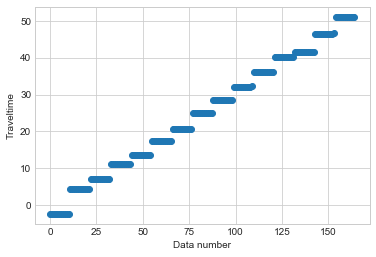

In [8]:
# call the actual raytracing method

tt = g.raytrace(slowness, src, rcv)

plt.plot(tt,'o')
plt.xlabel('Data number')
plt.ylabel('Traveltime')
plt.show()

Add some noise to the data

In [9]:
noise_variance = 1.e-3;  # 1 ms
tt += noise_variance*np.random.randn(tt.size)

Combine the event IDs, travel times, and receiver locations

In [10]:
data = np.hstack((src[:,0].reshape((-1,1)), tt.reshape((-1,1)), rcv))

### Initial hypocenter locations & velocity model

Note that for efficiency reason when computing matrix M, initial hypocenters
should _not_ be equal for any two event, e.g. they shoud all be different.

Here we place the initial coordinates more or less in the center of the grid.

In [11]:
hinit = np.vstack((np.arange(nev),
                   np.linspace(0., 50., nev),
                   150. + 0.1*np.random.randn(nev),
                   150. + 0.1*np.random.randn(nev),
                    35. + 0.1*np.random.randn(nev))).T

Initial velocity model is homogeneous

In [12]:
Vinit = 3900.0 + np.zeros((g.getNumberOfNodes(),))

### Velocity data points

For illustrative purposes, let's add a couple of velocity data points to constrain the inversion

In [13]:
Vpts = np.array([[Vz(1.), 100.0, 100.0, 1.],
                 [Vz(1.), 100.0, 200.0, 1.],
                 [Vz(1.), 200.0, 100.0, 1.],
                 [Vz(1.), 200.0, 200.0, 1.],
                 [Vz(11.), 112.0, 148.0, 11.0],
                 [Vz(5.), 152.0, 108.0, 5.0],
                 [Vz(75.), 152.0, 108.0, 75.0],
                 [Vz(11.), 192.0, 148.0, 11.0],])

##### Calibration shots

Let's use 5 shots recorded at most receivers

In [14]:
ncal = 5
cal = np.vstack((5+np.arange(ncal),
                 np.zeros(ncal),
                 160. +  5.*np.random.randn(ncal),
                 130. +  5.*np.random.randn(ncal),
                  45. +  5.*np.random.randn(ncal))).T

cal = np.kron(cal,np.ones((nsta,1)))
rcv_cal = np.array([[112., 115., 13.],
                [151., 117., 17.],
                [180., 115., 16.],
                [113., 145., 11.],
                [160., 150., 17.],
                [185., 149., 15.],
                [117., 184., 11.],
                [155., 192.,  9.],
                [188., 188., 10.],
                [188., 186., 30.],
                [188., 183., 60.]])
rcv_cal = np.kron(np.ones((ncal,1)), rcv_cal)

ind = np.ones(rcv_cal.shape[0], dtype=bool)
ind[3] = 0
ind[13] = 0
ind[15] = 0
cal = cal[ind,:]
rcv_cal = rcv_cal[ind,:]

tcal = g.raytrace(slowness, cal, rcv_cal)
caldata = np.column_stack((cal[:,0], tcal, rcv_cal, cal[:,2:]))

Before running the joint hypocenter-velocity inversion (JHVI), we use the constant velocity location algorithm.  This will improve convergence of the JHVI.

In [15]:
hinit2, res = hypo.hypoloc(data, V=4000., hinit=hinit, maxit=15, convh=1., verbose=True)


 *** Hypocenter inversion ***

Locating hypocenters no 0
     Converged at iteration 2
Locating hypocenters no 1
     Converged at iteration 2
Locating hypocenters no 2
     Converged at iteration 1
Locating hypocenters no 3
     Converged at iteration 3
Locating hypocenters no 4
     Converged at iteration 1
Locating hypocenters no 5
     Converged at iteration 2
Locating hypocenters no 6
     Converged at iteration 2
Locating hypocenters no 7
     Converged at iteration 1
Locating hypocenters no 8
     Converged at iteration 1
Locating hypocenters no 9
     Converged at iteration 1
Locating hypocenters no 10
     Converged at iteration 2
Locating hypocenters no 11
     Converged at iteration 2
Locating hypocenters no 12
     Converged at iteration 2
Locating hypocenters no 13
     Converged at iteration 1
Locating hypocenters no 14
     Converged at iteration 2

 ** Inversion complete **



Look now at error on hypocenter location

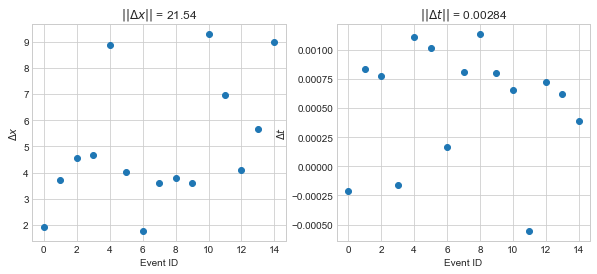

In [16]:
err_x = hinit2[:,2:5] - h_true[:,2:5]
err_x = np.sqrt(np.sum(err_x**2, axis=1))
err_t = hinit2[:,1] - h_true[:,1]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(err_x,'o')
plt.ylabel(r'$\Delta x$')
plt.xlabel('Event ID')
plt.title(r'$\|\|\Delta x\|\|$ = {0:3.2f}'.format(np.linalg.norm(err_x)))
plt.subplot(122)
plt.plot(err_t,'o')
plt.ylabel(r'$\Delta t$')
plt.xlabel('Event ID')
plt.title(r'$\|\|\Delta t\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_t)))

plt.show()

### Joint hypocenter-velocity Inversion parameters

Define inversion parameters

In [17]:
Vlim = (3500., 4500., 1.0)
dmax = (50., 5., 2.e-3)
lagran = (1., 1., 1., 0.5)   # lambda, gamma, alpha, wzK

par = hypo.InvParams(maxit=5, maxit_hypo=10, conv_hypo=2, Vlim=Vlim, dmax=dmax,
                     lagrangians=lagran, invert_vel=True, verbose=True)

Run the inversion


 *** Joint hypocenter-velocity inversion ***

Building velocity data point matrix D
Building regularization matrix K

Starting iterations
Iteration 1 - Updating velocity model
                Updating penalty vector
                Raytracing


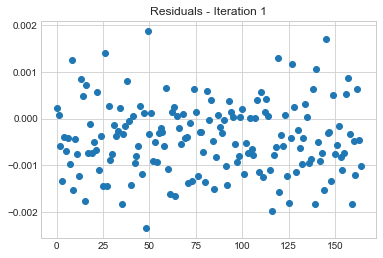

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
Iteration 1 - Relocating events
                Updating event ID 0 (1/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 1 (2/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 2 (3/15)
        

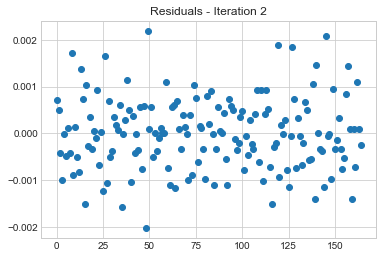

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
Iteration 2 - Relocating events
                Updating event ID 0 (1/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 1 (2/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 2 (3/15)
        

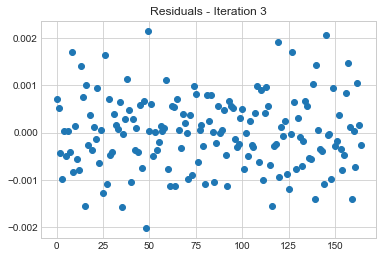

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
Iteration 3 - Relocating events
                Updating event ID 0 (1/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 1 (2/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 2 (3/15)
        

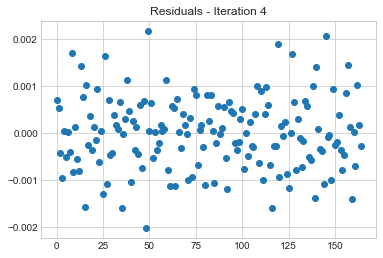

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
Iteration 4 - Relocating events
                Updating event ID 0 (1/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 1 (2/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 2 (3/15)
        

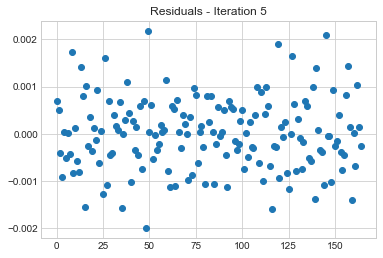

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
Iteration 5 - Relocating events
                Updating event ID 0 (1/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 1 (2/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 2 (3/15)
        

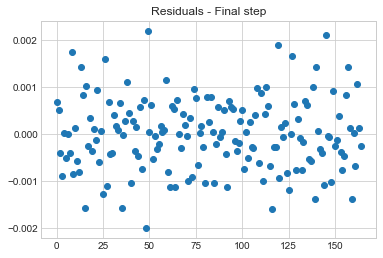


 ** Inversion complete **



In [18]:
h, V, sc, res = hypo.jointHypoVel(par, g, data, Vinit, hinit2, caldata=caldata, Vpts=Vpts)

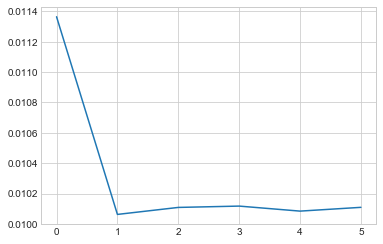

In [19]:
plt.plot(res[0])
plt.show()

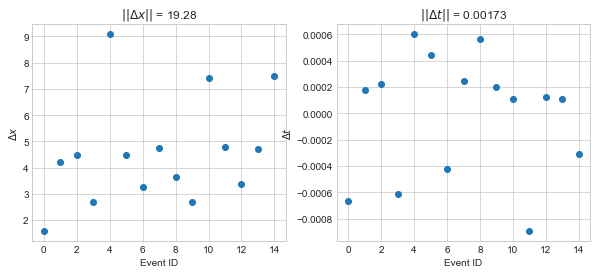

In [20]:
err_x = h[:,2:5] - h_true[:,2:5]
err_x = np.sqrt(np.sum(err_x**2, axis=1))
err_t = h[:,1] - h_true[:,1]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(err_x,'o')
plt.ylabel(r'$\Delta x$')
plt.xlabel('Event ID')
plt.title(r'$\|\|\Delta x\|\|$ = {0:3.2f}'.format(np.linalg.norm(err_x)))
plt.subplot(122)
plt.plot(err_t,'o')
plt.ylabel(r'$\Delta t$')
plt.xlabel('Event ID')
plt.title(r'$\|\|\Delta t\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_t)))

plt.show()

We can see a little improvement on relocation over constant velocity inversion.  What about the velocity model?

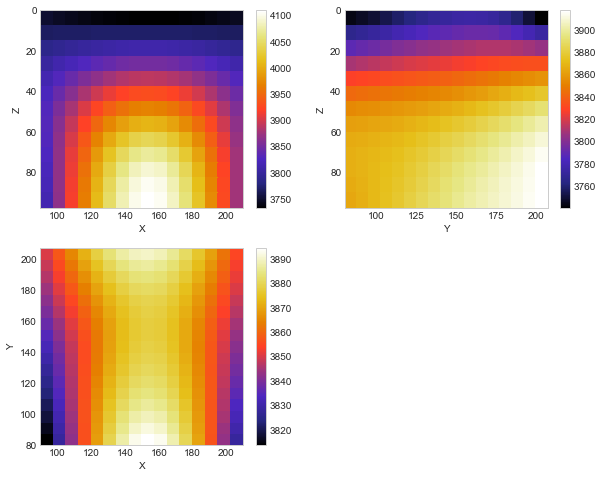

In [21]:
V3d = V.reshape(g.shape)

plt.figure(figsize=(10,8))
plt.subplot(221)
plt.pcolor(x,z,np.squeeze(V3d[:,1,:].T), cmap='CMRmap',), plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(222)
plt.pcolor(y,z,np.squeeze(V3d[1,:,:].T), cmap='CMRmap'), plt.gca().invert_yaxis()
plt.xlabel('Y')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(223)
plt.pcolor(x,y,np.squeeze(V3d[:,:,4].T), cmap='CMRmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()


plt.show()